In [35]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [61]:
# load the mnist dataset
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [48]:
# build the neural network
import os
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [238]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512,10),
    )
  
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits
  

100%|██████████| 500/500 [00:06<00:00, 82.94it/s]


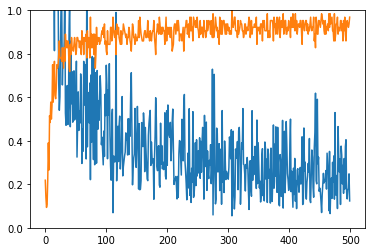

In [267]:
model = Model()
#training
losses, accuracies = [],[]
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for i in trange(500):
  samp = np.random.randint(0, X_train.shape[0], 64)
  X = torch.from_numpy(X_train[samp]).double()
  y = torch.from_numpy(Y_train[samp])
  model.zero_grad()
  #pred and loss
  pred = model(X)
  pred_x = torch.argmax(pred, dim=1)
  accuracy = (pred_x == y).float().mean()
  loss = loss_fn(pred, y)
  loss = loss.mean()
  
  #back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  losses.append(loss.item())
  accuracies.append(accuracy.item())
  
#plot
plt.ylim(0, 1)
plot(losses)
plot(accuracies)

In [268]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).double()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9307

(<matplotlib.image.AxesImage at 0x134c14f70>, 1)

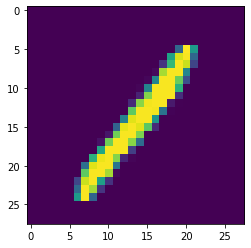

In [269]:
i = int(np.random.randint(0,X_test.shape, 1))
imshow(X_test[i]), Y_test_preds[i]